In [1]:
# -*- coding: utf-8 -*-
import statsmodels.api as sm
import numpy as np
import scipy as sp
import math


def LevinsonDurbin(r, lpcOrder):
    """
    from http://aidiary.hatenablog.com/entry/20120415/1334458954
    """
    a = np.zeros(lpcOrder + 1, dtype=np.float64)
    e = np.zeros(lpcOrder + 1, dtype=np.float64)

    a[0] = 1.0
    a[1] = - r[1] / r[0]
    e[1] = r[0] + r[1] * a[1]
    lam = - r[1] / r[0]

    for k in range(1, lpcOrder):
        lam = 0.0
        for j in range(k + 1):
            lam -= a[j] * r[k + 1 - j]
        lam /= e[k]

        U = [1]
        U.extend([a[i] for i in range(1, k + 1)])
        U.append(0)

        V = [0]
        V.extend([a[i] for i in range(k, 0, -1)])
        V.append(1)

        a = np.array(U) + lam * np.array(V)
        e[k + 1] = e[k] * (1.0 - lam * lam)

    return a, e[-1]


class _SDAR_1Dim(object):
    def __init__(self, r, order):
        self._r = r
        self._mu = np.random.random()
        self._sigma = np.random.random()
        self._order = order
        self._c = np.random.random(self._order+1) / 100.0

    def update(self, x, term):
        assert len(term) >= self._order, "term must be order or more"
        term = np.array(term)
        self._mu = (1.0 - self._r) * self._mu + self._r * x
        for i in range(1, self._order + 1):
            self._c[i] = (1 - self._r) * self._c[i] + self._r * (x - self._mu) * (term[-i] - self._mu)
        self._c[0] = (1-self._r)*self._c[0]+self._r * (x-self._mu)*(x-self._mu)
        what, e = LevinsonDurbin(self._c, self._order)
        xhat = np.dot(-what[1:], (term[::-1] - self._mu))+self._mu
        self._sigma = (1-self._r)*self._sigma + self._r * (x-xhat) * (x-xhat)
        return -math.log(math.exp(-0.5*(x-xhat)**2/self._sigma)/((2 * math.pi)**0.5*self._sigma**0.5)), xhat


class _ChangeFinderAbstract(object):
    def _add_one(self, one, ts, size):
        ts.append(one)
        if len(ts) == size+1:
            ts.pop(0)

    def _smoothing(self, ts):
        return sum(ts)/float(len(ts))


class ChangeFinder(_ChangeFinderAbstract):
    def __init__(self, r=0.5, order=1, smooth=7):
        assert order > 0, "order must be 1 or more."
        assert smooth > 2, "term must be 3 or more."
        self._smooth = smooth
        self._smooth2 = int(round(self._smooth/2.0))
        self._order = order
        self._r = r
        self._ts = []
        self._first_scores = []
        self._smoothed_scores = []
        self._second_scores = []
        self._sdar_first = _SDAR_1Dim(r, self._order)
        self._sdar_second = _SDAR_1Dim(r, self._order)

    def update(self, x):
        score = 0
        predict = x
        predict2 = 0
        if len(self._ts) == self._order:  # 第一段学習
            score, predict = self._sdar_first.update(x, self._ts)
            self._add_one(score, self._first_scores, self._smooth)
        self._add_one(x, self._ts, self._order)
        second_target = None
        if len(self._first_scores) == self._smooth:  # 平滑化
            second_target = self._smoothing(self._first_scores)
        if second_target and len(self._smoothed_scores) == self._order:  # 第二段学習
            score, predict2 = self._sdar_second.update(second_target, self._smoothed_scores)
            self._add_one(score,
                          self._second_scores, self._smooth2)
        if second_target:
            self._add_one(second_target, self._smoothed_scores, self._order)
        if len(self._second_scores) == self._smooth2:
            return self._smoothing(self._second_scores), predict, second_target
        else:
            return 0.0, predict, second_target


class ChangeFinderARIMA(_ChangeFinderAbstract):
    def __init__(self, term=30, smooth=7, order=(1, 0, 0)):
        assert smooth > 2, "term must be 3 or more."
        assert term > smooth, "term must be more than smooth"

        self._term = term
        self._smooth = smooth
        self._smooth2 = int(round(self._smooth/2.0))
        self._order = order
        self._ts = []
        self._first_scores = []
        self._smoothed_scores = []
        self._second_scores = []

    def _calc_outlier_score(self, ts, target):
        def outlier_score(residuals, x):
            m = residuals.mean()
            s = np.std(residuals, ddof=1)
            return -sp.stats.norm.logpdf(x, m, s)
        ts = np.array(ts)
        arima_model = sm.tsa.ARIMA(ts, self._order)
        result = arima_model.fit(disp=0)
        pred = result.forecast(1)[0][0]
        return outlier_score(result.resid, x=pred-target), pred

    def update(self, x):
        score = 0
        predict = x
        predict2 = 0
        if len(self._ts) == self._term:  # 第一段学習
            try:
                score, predict = self._calc_outlier_score(self._ts, x)
                self._add_one(score, self._first_scores, self._smooth)
            except Exception:
                self._add_one(x, self._ts, self._term)
                return 0, predict
        self._add_one(x, self._ts, self._term)
        second_target = None
        if len(self._first_scores) == self._smooth:  # 平滑化
            second_target = self._smoothing(self._first_scores)
        if second_target and len(self._smoothed_scores) == self._term:  # 第二段学習
            try:
                score, predict2 = self._calc_outlier_score(self._smoothed_scores, second_target)
                self._add_one(score,
                              self._second_scores, self._smooth2)
            except Exception:
                self._add_one(second_target, self._smoothed_scores, self._term)
                return 0, predict
        if second_target:
            self._add_one(second_target, self._smoothed_scores, self._term)
        if len(self._second_scores) == self._smooth2:
            return self._smoothing(self._second_scores), predict
        else:
            return 0.0, predict


In [1]:
import os
os.getcwd()

'C:\\Users\\neki-at\\internship2019summer\\internship_development\\ipynb'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn

if "ipynb" in os.getcwd():
    os.chdir("..")

plt.style.use("seaborn")
data = pd.read_csv("./anomaly_data/dockerfiles_rubisdb_1_20190818-1900_20190819-0900_5.csv")
df_1 = data["node_cpuusage"]
X = df_1.as_matrix()

C:\Users\neki-at\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [6]:
cf = ChangeFinder(r = 0.00005, order=1, smooth=7)
ret = []
predict_list = []
ts_list = []
for i in X:
    score, predict, e = cf.update(i)
    ret.append(score)
    predict_list.append(predict)
    ts_list.append(e)
    


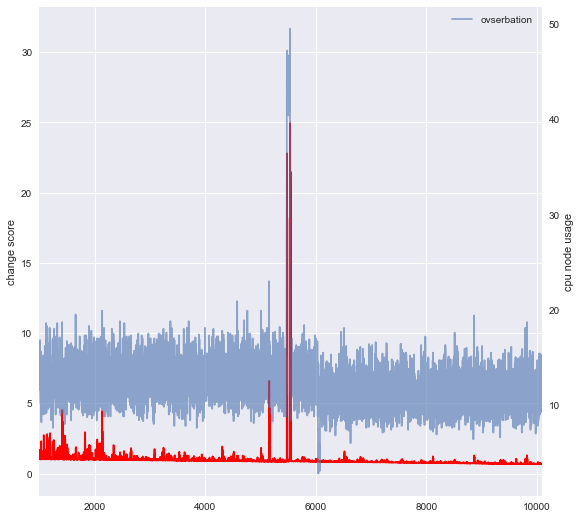

In [39]:
fig = plt.figure(figsize = (9, 9))
ax = fig.add_subplot(111)
plt.xlim(1000, 10080)
ax.plot(ret, color = "red", label = 'change score')
ax.set_ylabel("change score")
ax2 = ax.twinx()
ax2.grid(False)
ax2.plot(X, label = 'ovserbation', alpha = 0.6)
ax2.set_ylabel("cpu node usage")
plt.legend()
plt.savefig("./saving_image/change_finder.png")
plt.show()

In [21]:
cf = ChangeFinder(r = 0.005, order=1, smooth=7)
ret = []
predict_list = []
ts_list = []
for i in X:
    score, predict, e = cf.update(i)
    ret.append(score)
    predict_list.append(predict)
    ts_list.append(e)
    
cf_2 =  ChangeFinder(r = 0.00005, order=1, smooth=7)
ret_2 = []
predict_list_2 = []
ts_list_2 = []
for i in X:
    score, predict, e = cf.update(i)
    ret_2.append(score)
    predict_list_2.append(predict)
    ts_list_2.append(e)
    

In [33]:
cf = ChangeFinder(r = 0.0001, order=1, smooth=7)
ret = []
predict_list = []
ts_list = []
for i in X:
    score, predict, e = cf.update(i)
    ret.append(score)
    predict_list.append(predict)
    ts_list.append(e)
    

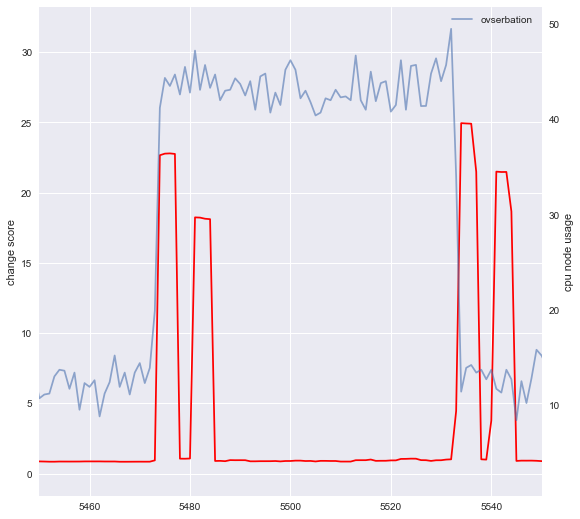

In [35]:
fig = plt.figure(figsize = (9, 9))
ax = fig.add_subplot(111)
plt.xlim(5400, 5600)
ax.plot(ret, color = "red", label = 'change score')
ax.set_ylabel("change score")
ax2 = ax.twinx()
ax2.grid(False)
ax2.plot(X, label = 'ovserbation', alpha = 0.6)
ax2.set_ylabel("cpu node usage")
plt.xlim(5450, 5550)
plt.legend()
plt.savefig("./saving_image/change_finder_r=0.0001.png")
plt.show()

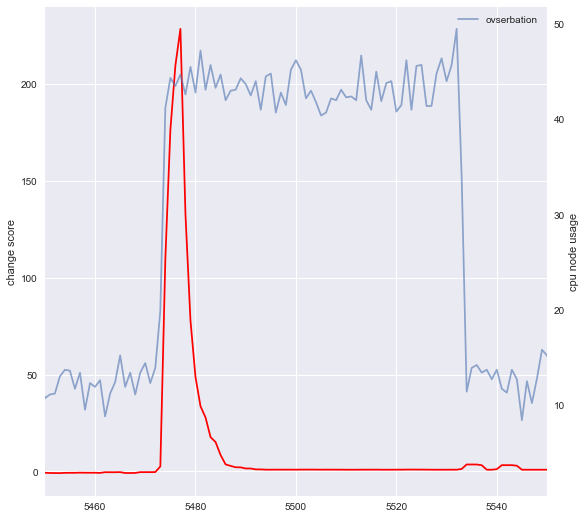

In [15]:
fig = plt.figure(figsize = (9, 9))
ax = fig.add_subplot(111)
#plt.xlim(5400, 5600)
ax.plot(ret_2, color = "red", label = 'change score')
ax.set_ylabel("change score")
ax2 = ax.twinx()
ax2.grid(False)
ax2.plot(X, label = 'ovserbation', alpha = 0.6)
ax2.set_ylabel("cpu node usage")
plt.xlim(5450, 5550)
plt.legend()
#plt.savefig("./saving_image/change_finder.png")
plt.show()

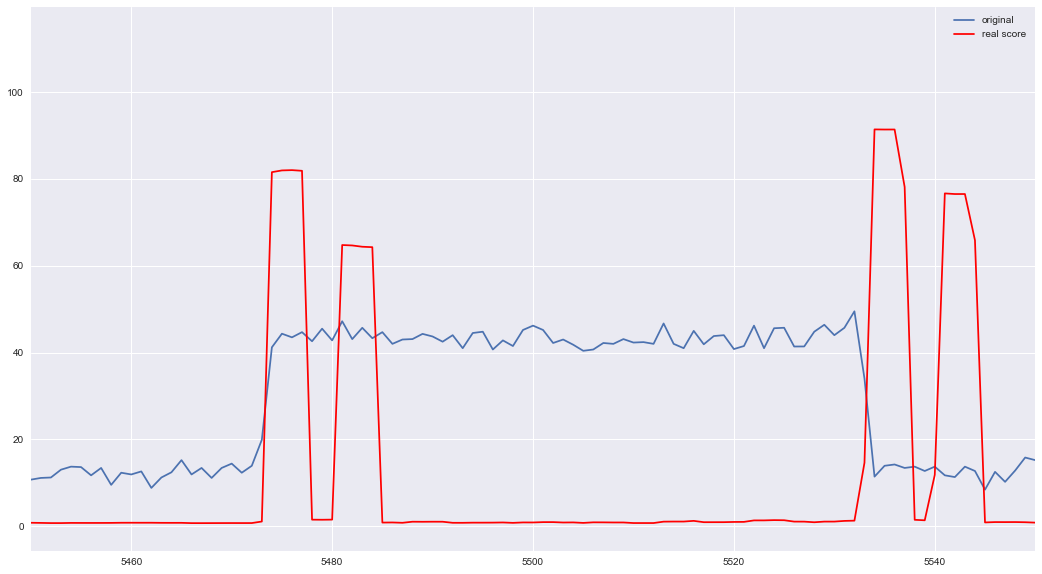

In [13]:
plt.figure(figsize = (18, 10))
#plt.plot(ts_list, label = '1st score')
plt.xlim(5450, 5550)
#plt.plot(predict_list, label = 'predict', color = "red")
plt.plot(X, label = 'original')
plt.plot(ret, color = 'red', label = 'real score')
#plt.ylim(-1, 75)
plt.legend()
plt.show()

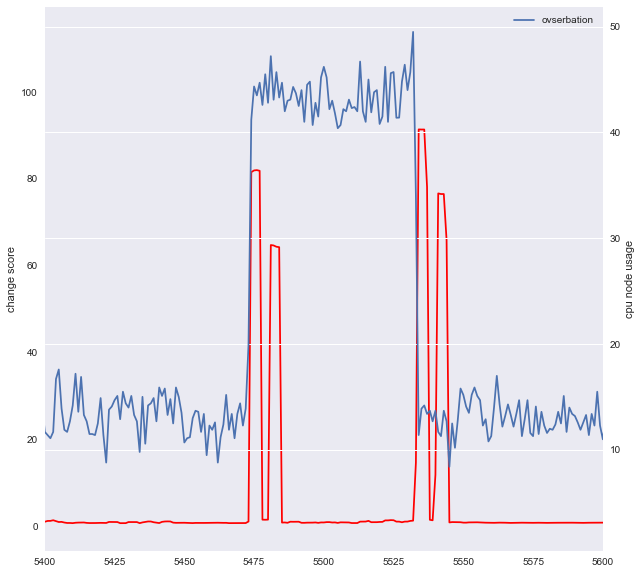

In [36]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
plt.xlim(5400, 5600)
ax.plot(ret, color = "red", label = 'change score')
ax.set_ylabel("change score")
ax2 = ax.twinx()
ax.grid(False)
ax2.plot(X, label = 'ovserbation')
ax2.set_ylabel("cpu node usage")
plt.legend()
plt.savefig("./saving_image/change_finder_local.png")
plt.show()

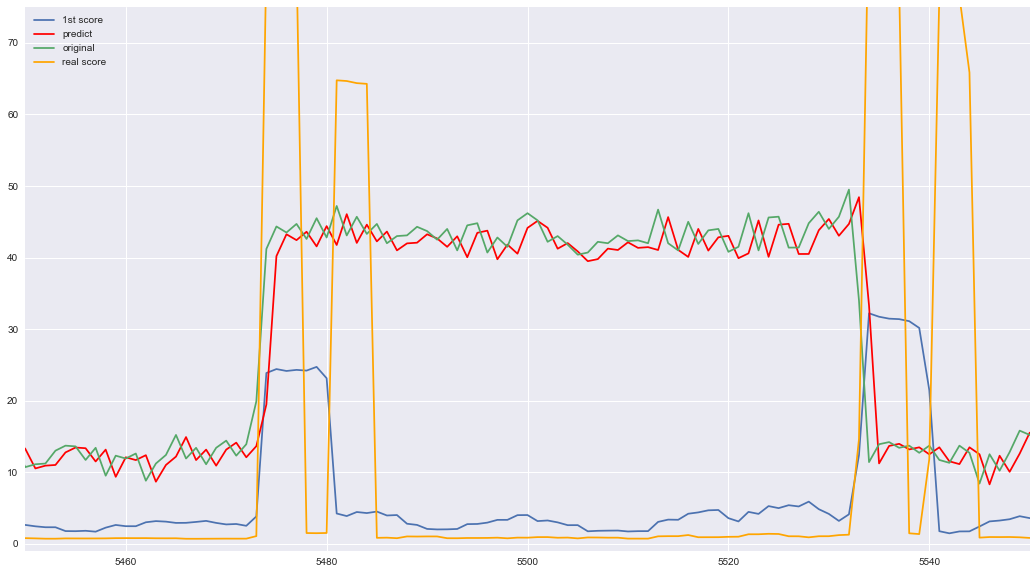

In [10]:
plt.figure(figsize = (18, 10))
plt.plot(ts_list, label = '1st score')
plt.xlim(5450, 5550)
plt.plot(predict_list, label = 'predict', color = "red")
plt.plot(X, label = 'original')
plt.plot(ret, color = 'orange', label = 'real score')
plt.ylim(-1, 75)
plt.legend()
plt.show()